In [1]:
import os, re, glob, cv2, csv
import numpy as np
import cupy as cp
from cupyx.scipy import ndimage as cpx_ndimage  # Import CuPy's GPU ndimage module
import tifffile as tiff
import scipy as sp
from scipy import ndimage, io as sio
from scipy.ndimage import maximum_filter, label, find_objects
from scipy.stats import chi2, lognorm, poisson, norm
from scipy.optimize import curve_fit
from skimage.feature import peak_local_max
from natsort import natsorted
import trackpy as tp
import pandas as pd
import multiprocessing as mp
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.widgets import Slider
from matplotlib import animation, rc
import matplotlib.colors as mcolors
from tqdm import tqdm
from IPython.display import display, Image

# Set up matplotlib for animations
rc('animation', html='jshtml')

# Suppress specific warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)  # ignore warnings for specific matplotlib commands which will be outdated soon


In [2]:
def convert_to_code_path(windows_path):
    """
    Converts a Windows file path with single backslashes to a format with double backslashes for use in Python code.

    Parameters:
    - windows_path: str
        The original Windows file path (e.g., 'C:\\Users\\YourName\\Folder').

    Returns:
    - str
        The modified path with double backslashes, suitable for Python (e.g., 'C:\\\\Users\\\\YourName\\\\Folder').
    """
    # Replace each single backslash with a double backslash
    return windows_path.replace("\\", "\\\\")

In [4]:
# def wasserstein_distance(u_samples, v_samples, p=1):
#     """
#     Computes the 1-Wasserstein or 2-Wasserstein distance between two discrete probability measures.

#     Parameters:
#     u_samples (array-like): Sample vector for the first distribution.
#     v_samples (array-like): Sample vector for the second distribution.
#     p (int, optional): Order of the Wasserstein distance. Must be either 1 or 2. Default is 1.

#     Returns:
#     float: The p-Wasserstein distance between the distributions.
#     """
#     u_samples_sorted = np.sort(np.asarray(u_samples))
#     v_samples_sorted = np.sort(np.asarray(v_samples))
    
#     if p == 1:
#         all_samples = np.unique(np.concatenate([u_samples_sorted, v_samples_sorted]))
        
#         u_cdf = find_interval(u_samples_sorted, all_samples[:-1]) / len(u_samples_sorted)
#         v_cdf = find_interval(v_samples_sorted, all_samples[:-1]) / len(v_samples_sorted)
        
#         return np.sum(np.abs(u_cdf - v_cdf) * np.diff(all_samples))
    
#     elif p == 2:
#         u_N = len(u_samples_sorted)
#         v_N = len(v_samples_sorted)
        
#         all_prob = np.unique(np.concatenate([(np.arange(u_N + 1) / u_N), (np.arange(v_N + 1) / v_N)]))
        
#         u_icdf = u_samples_sorted[(all_prob[:-1] * u_N).astype(int)]
#         v_icdf = v_samples_sorted[(all_prob[:-1] * v_N).astype(int)]
        
#         return np.sqrt(np.sum((u_icdf - v_icdf) ** 2 * np.diff(all_prob)))
    
#     else:
#         raise ValueError("Only p=1 or p=2 allowed.")

# def find_interval(bounds, vals):
#     """
#     Finds the index for each value in vals such that bounds[idx] <= val < bounds[idx + 1].

#     Parameters:
#     bounds (array-like): Sorted array of boundaries.
#     vals (array-like): Values to find the corresponding interval indices.

#     Returns:
#     np.ndarray: Indices corresponding to the intervals.
#     """
#     bounds = np.append(bounds, np.inf)  # Append infinity to handle last interval
#     idx = np.searchsorted(bounds, vals, side='right') - 1
#     return idx


In [3]:
def wasserstein_distance(u_samples, v_samples, p=1):
    """
    Computes the 1-Wasserstein or 2-Wasserstein distance between two discrete probability measures.

    Parameters:
    u_samples (array-like): Sample vector for the first distribution.
    v_samples (array-like): Sample vector for the second distribution.
    p (int, optional): Order of the Wasserstein distance. Must be either 1 or 2. Default is 1.

    Returns:
    float: The p-Wasserstein distance between the distributions.
    """
    u_samples_sorted = np.sort(np.asarray(u_samples))
    v_samples_sorted = np.sort(np.asarray(v_samples))
    
    if p == 1:
        all_samples = np.unique(np.concatenate([u_samples_sorted, v_samples_sorted]))
        
        u_cdf = np.searchsorted(u_samples_sorted, all_samples, side='right') / len(u_samples_sorted)
        v_cdf = np.searchsorted(v_samples_sorted, all_samples, side='right') / len(v_samples_sorted)

        return np.sum(np.abs(u_cdf[:-1] - v_cdf[:-1]) * np.diff(all_samples))
    
    elif p == 2:
        u_N = len(u_samples_sorted)
        v_N = len(v_samples_sorted)
        
        all_prob = np.unique(np.concatenate([(np.arange(u_N + 1) / u_N), (np.arange(v_N + 1) / v_N)]))

        u_icdf = np.interp(all_prob[:-1], np.arange(u_N) / u_N, u_samples_sorted)
        v_icdf = np.interp(all_prob[:-1], np.arange(v_N) / v_N, v_samples_sorted)

        return np.sqrt(np.sum((u_icdf - v_icdf) ** 2 * np.diff(all_prob)))
    
    else:
        raise ValueError("Only p=1 or p=2 allowed.")


## Wasserstein Testing

Area between the CDFs: 1.0007


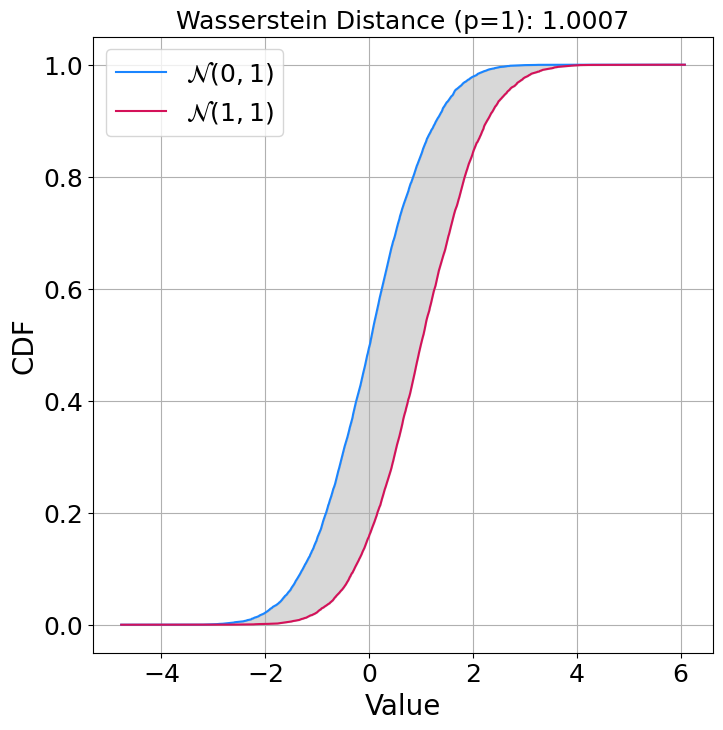

In [8]:
# Generate the two normal distributions
u_samples = np.random.normal(loc=0, scale=1, size=10000)
v_samples = np.random.normal(loc=1, scale=1, size=10000)

# Compute Wasserstein distances
w1 = wasserstein_distance(u_samples, v_samples, p=1)
w2 = wasserstein_distance(u_samples, v_samples, p=2)

# Compute empirical CDFs
u_sorted = np.sort(u_samples)
v_sorted = np.sort(v_samples)
cdf_u = np.linspace(0, 1, len(u_sorted))
cdf_v = np.linspace(0, 1, len(v_sorted))

# Extend the domain of both distributions
# Define new domain
x_min = min(u_sorted[0], v_sorted[0]) - 1
x_max = max(u_sorted[-1], v_sorted[-1]) + 1

# Create the new extended domain
new_domain = np.linspace(x_min, x_max, 1000)

# Interpolate the CDFs onto the new domain
cdf_u_extended = np.interp(new_domain, u_sorted, cdf_u, left=0, right=1)
cdf_v_extended = np.interp(new_domain, v_sorted, cdf_v, left=0, right=1)

# Fill the left side with 0 and right side with 1
if new_domain[0] < u_sorted[0]:
    cdf_u_extended[:np.searchsorted(new_domain, u_sorted[0])] = 0
if new_domain[0] < v_sorted[0]:
    cdf_v_extended[:np.searchsorted(new_domain, v_sorted[0])] = 0
if new_domain[-1] > u_sorted[-1]:
    cdf_u_extended[np.searchsorted(new_domain, u_sorted[-1]):] = 1
if new_domain[-1] > v_sorted[-1]:
    cdf_v_extended[np.searchsorted(new_domain, v_sorted[-1]):] = 1

# Calculate the area between the CDFs using numerical integration (trapezoidal rule)
area_between_cdfs = np.trapz(np.abs(cdf_v_extended - cdf_u_extended), new_domain)

# Plot the CDFs
plt.figure(figsize=(8, 8))
plt.plot(new_domain, cdf_u_extended, label=r'$\mathcal{N}(0, 1)$', color="#1A85FF")
plt.plot(new_domain, cdf_v_extended, label=r'$\mathcal{N}(1, 1)$', color="#D41159")


# Fill the area between CDFs
plt.fill_between(new_domain, cdf_u_extended, cdf_v_extended, color="gray", alpha=0.3)

# Labels and legend
plt.xlabel("Value", fontsize=20)
plt.ylabel("CDF", fontsize=20)
plt.tick_params(axis='both', labelsize=18)

# plt.title(f"Wasserstein Distances\n1-Wasserstein: {w1:.4f}, 2-Wasserstein: {w2:.4f}\nArea between CDFs: {area_between_cdfs:.4f}")
plt.title(f"Wasserstein Distance (p=1): {w1:.4f}",fontsize=18)
plt.legend(fontsize=18)
plt.grid()


# Print the area between the curves
print(f"Area between the CDFs: {area_between_cdfs:.4f}")
plt.savefig('E:\\Spandan\\2D_Neurons_Paper\\Spring2025\\wasserstein-1.svg', format='svg')
plt.show()

In [46]:
data_folder = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\minimum_8_frames')
tp_trajectories_early = pd.read_csv(data_folder+'\\early_stage_angles_with_displacement.csv')
tp_trajectories_middle = pd.read_csv(data_folder+'\\middle_stage_angles_with_displacement.csv')
tp_trajectories_late = pd.read_csv(data_folder+'\\late_stage_angles_with_displacement.csv')

## Non-cumulative wrt processes

In [39]:
def plot_normalized_weighted_angular_histograms_comparison(early_df, middle_df, late_df, bins=20, transparency=1.0, save_path=None):
    # Convert angular differences to radians (if they are in degrees)
    early_df['ang_diff_rad'] = np.deg2rad(early_df['ang_diff_process'])
    middle_df['ang_diff_rad'] = np.deg2rad(middle_df['ang_diff_process'])
    late_df['ang_diff_rad'] = np.deg2rad(late_df['ang_diff_process'])

    # Define bin edges and centers in radians
    bin_edges = np.linspace(0, np.pi / 2, bins + 1)  # Radians: 0 to π/2
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Midpoints for plotting

    def compute_weighted_stats(histograms):
        """Compute weighted median and 0.5 * IQR for histograms."""
        histograms = np.array(histograms)
        if histograms.size == 0:
            return np.zeros_like(bin_centers), np.zeros_like(bin_centers)
        
        # Compute median and IQR for each bin across histograms
        medians = np.median(histograms, axis=0)
        q1 = np.percentile(histograms, 25, axis=0)
        q3 = np.percentile(histograms, 75, axis=0)
        iqr = q3 - q1
        errors = 0.5 * iqr  # Error bars: 0.5 * IQR
        return medians, errors

    def process_stage(stage_df):
        """Process DataFrame to compute normalized weighted histograms."""
        histograms = []
        for file_address in stage_df['file_address'].unique():
            group_data = stage_df[stage_df['file_address'] == file_address]
            angles = group_data['ang_diff_rad']
            weights = group_data['displacement_scaled']

            # Compute weighted histogram
            hist, _ = np.histogram(angles, bins=bin_edges, weights=weights)
            hist_sum = hist.sum()
            if hist_sum > 0:  # Avoid division by zero
                histograms.append(hist / hist_sum)  # Normalize
        return histograms

    # Process each stage
    early_histograms = process_stage(early_df)
    middle_histograms = process_stage(middle_df)
    late_histograms = process_stage(late_df)

    # Compute statistics for each stage
    early_median, early_error = compute_weighted_stats(early_histograms)
    middle_median, middle_error = compute_weighted_stats(middle_histograms)
    late_median, late_error = compute_weighted_stats(late_histograms)

    # Plot setup
    dataset_labels = ['Early', 'Middle', 'Late']
    color_labels = ['#d5814f', '#87a03e', '#978deb']

    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot each stage with median and error bars
    for median, error, color, label in zip(
        [early_median, middle_median, late_median],
        [early_error, middle_error, late_error],
        color_labels,
        dataset_labels
    ):
        ax.errorbar(bin_centers, median, yerr=error, fmt='--o',
                    color=color, label=f"{label} Stage", markersize=5,
                    capsize=3, linewidth=1.5, alpha=transparency)
        ax.fill_between(bin_centers, median - error, median + error,
                        color=color, alpha=0.1)

    # Customize plot
    ax.set_xlabel('Angular Difference (degrees)', fontsize=16)
    ax.set_ylabel('Normalized Counts', fontsize=16)
    ax.set_ylim([0, 0.16])
    ax.set_title("Angular Alignment of Tracks wrt Neuronal Processes", fontsize=16)
    ax.legend(loc='upper right', fontsize=14)
    ax.tick_params(axis='both', labelsize=14)

    # Show plot or save
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, format='svg')
    plt.show()


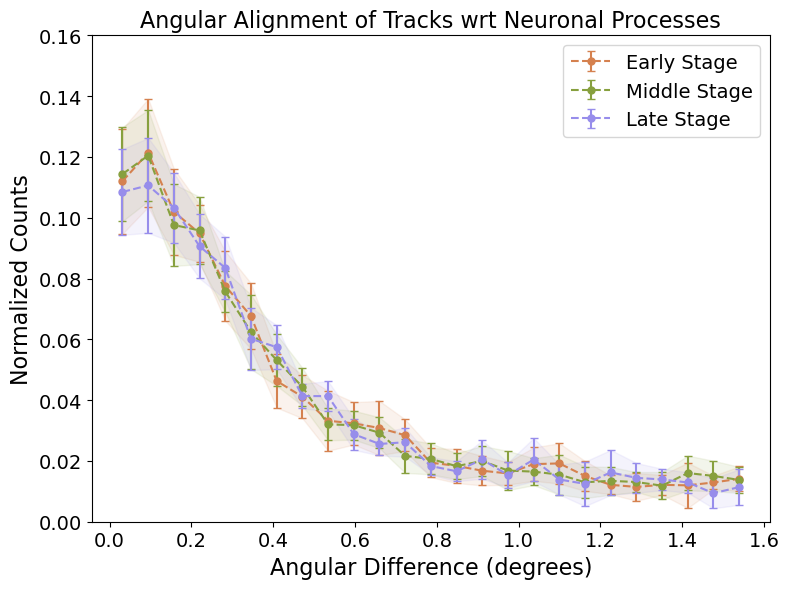

In [40]:
save_folder = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Combined Plots_glass_vs_glass')
plot_normalized_weighted_angular_histograms_comparison(tp_trajectories_early, tp_trajectories_middle, tp_trajectories_late, bins=25, save_path=save_folder+'\\early_vs_middle_vs_late_non_cumulative_angles_wrt_process.svg')



## Cumulative wrt processes

In [42]:
def plot_cumulative_weighted_angular_histograms_comparison(early_df, middle_df, late_df, bins=20, transparency=1.0, save_path=None):
    # Convert angular differences to radians (if they are in degrees)
    early_df['ang_diff_rad'] = np.deg2rad(early_df['ang_diff_process'])
    middle_df['ang_diff_rad'] = np.deg2rad(middle_df['ang_diff_process'])
    late_df['ang_diff_rad'] = np.deg2rad(late_df['ang_diff_process'])

    # Define bin edges and centers in radians
    bin_edges = np.linspace(0, np.pi / 2, bins + 1)  # Radians: 0 to π/2
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Midpoints for plotting

    def compute_weighted_stats(histograms):
        """Compute weighted median and 0.5 * IQR for cumulative histograms."""
        histograms = np.array(histograms)
        if histograms.size == 0:
            return np.zeros_like(bin_centers), np.zeros_like(bin_centers)

        # Compute cumulative histograms
        cumulative_histograms = np.cumsum(histograms, axis=1)

        # Normalize cumulative histograms
        cumulative_histograms /= cumulative_histograms[:, -1][:, np.newaxis]  # Normalize to 1

        # Compute median and IQR for each bin across cumulative histograms
        medians = np.median(cumulative_histograms, axis=0)
        q1 = np.percentile(cumulative_histograms, 25, axis=0)
        q3 = np.percentile(cumulative_histograms, 75, axis=0)
        iqr = q3 - q1
        errors = 0.5 * iqr  # Error bars: 0.5 * IQR
        return medians, errors

    def process_stage(stage_df):
        """Process DataFrame to compute normalized weighted histograms."""
        histograms = []
        for file_address in stage_df['file_address'].unique():
            group_data = stage_df[stage_df['file_address'] == file_address]
            angles = group_data['ang_diff_rad']
            weights = group_data['displacement_scaled']

            # Compute weighted histogram
            hist, _ = np.histogram(angles, bins=bin_edges, weights=weights)
            hist_sum = hist.sum()
            if hist_sum > 0:  # Avoid division by zero
                histograms.append(hist / hist_sum)  # Normalize
        return histograms

    # Process each stage
    early_histograms = process_stage(early_df)
    middle_histograms = process_stage(middle_df)
    late_histograms = process_stage(late_df)

    # Compute cumulative statistics for each stage
    early_median, early_error = compute_weighted_stats(early_histograms)
    middle_median, middle_error = compute_weighted_stats(middle_histograms)
    late_median, late_error = compute_weighted_stats(late_histograms)

    # Plot setup
    dataset_labels = ['Early', 'Middle', 'Late']
    color_labels = ['#d5814f', '#87a03e', '#978deb']

    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot each stage with cumulative median and error bars
    for median, error, color, label in zip(
        [early_median, middle_median, late_median],
        [early_error, middle_error, late_error],
        color_labels,
        dataset_labels
    ):
        ax.errorbar(bin_centers, median, yerr=error, fmt='--o',
                    color=color, label=f"{label} Stage", markersize=5,
                    capsize=3, linewidth=1.5, alpha=transparency)
        ax.fill_between(bin_centers, median - error, median + error,
                        color=color, alpha=0.1)

    # Customize plot
    ax.set_xlabel('Angular Difference (degrees)', fontsize=16)
    ax.set_ylabel('Cumulative Normalized Counts', fontsize=16)
    ax.set_ylim([-0.05, 1.05])  # Cumulative values range from 0 to 1
    ax.set_title("Angular Alignment of Tracks wrt Neuronal Processes", fontsize=16)
    ax.legend(loc='lower right', fontsize=14)
    ax.tick_params(axis='both', labelsize=14)

    # Show plot or save
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, format='svg')
    plt.show()


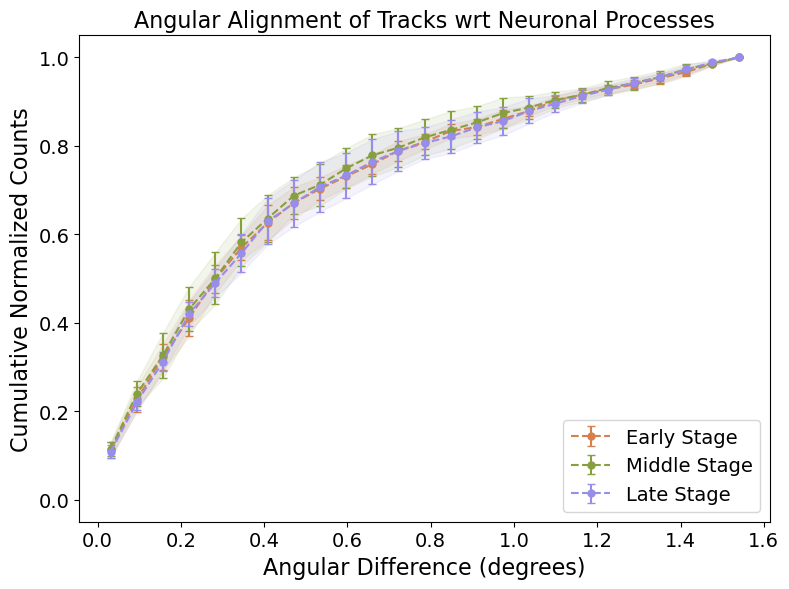

In [43]:
plot_cumulative_weighted_angular_histograms_comparison(tp_trajectories_early, tp_trajectories_middle, tp_trajectories_late, bins=25, save_path=save_folder+'\\early_vs_middle_vs_late_cumulative_angles_wrt_process.svg')

In [4]:
data_folder = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\minimum_8_frames')
tp_trajectories_early = pd.read_csv(data_folder+'\\early_stage.csv')
tp_trajectories_middle = pd.read_csv(data_folder+'\\middle_stage.csv')
tp_trajectories_late = pd.read_csv(data_folder+'\\late_stage.csv')

In [5]:
tp_trajectories_early

,Unnamed: 0.1,file_address,Unnamed: 0,particle,track_length,track_duration,distance,avg_velocity,inst_velocity,sinuosity
0,early_stage,E:\\Spandan\\2D_Neurons_Paper\\Glass\\div2\\co...,0,18,7.811891,50.01700,0.317139,0.380438,9.371084,24.632386
1,early_stage,E:\\Spandan\\2D_Neurons_Paper\\Glass\\div2\\co...,2,132,5.839743,14.00476,0.310246,1.329173,25.018964,18.822954
2,early_stage,E:\\Spandan\\2D_Neurons_Paper\\Glass\\div2\\co...,3,221,9.980221,28.00952,1.645486,3.524844,21.378919,6.065211
3,early_stage,E:\\Spandan\\2D_Neurons_Paper\\Glass\\div2\\co...,4,277,6.720853,16.00544,1.804994,6.766429,25.194631,3.723476
4,early_stage,E:\\Spandan\\2D_Neurons_Paper\\Glass\\div2\\co...,5,303,10.286458,22.00748,0.355664,0.969663,28.044441,28.921829
...,...,...,...,...,...,...,...,...,...,...
1420,early_stage,E:\\Spandan\\2D_Neurons_Paper\\Glass\\div5\\co...,44,2541,5.991057,14.00000,0.052745,0.226049,25.675958,113.586048
1421,early_stage,E:\\Spandan\\2D_Neurons_Paper\\Glass\\div5\\co...,45,2558,4.930662,18.00000,3.850771,12.835904,16.435540,1.280435
1422,early_stage,E:\\Spandan\\2D_Neurons_Paper\\Glass\\div5\\co...,46,2563,4.854031,14.00000,2.199400,9.426001,20.802992,2.206980
1423,early_stage,E:\\Spandan\\2D_Neurons_Paper\\Glass\\div5\\co...,47,2604,8.483613,16.00000,1.162799,4.360497,31.813550,7.295854


## Track length

In [112]:
def plot_histograms_track_length(df_list, data_folder, weighted=True, 
                                 track_length_col='track_length', track_duration_col='track_duration', 
                                 file_address_col='file_address', save_path=None, cumulative=False, show_middle=True):
    """
    Plot histograms of track lengths for multiple datasets, showing shaded regions for each dataset.
    Allows for both cumulative and non-cumulative histograms.

    Parameters:
    df_list : list of pandas DataFrames
        List containing DataFrames, each with 'track_length', 'track_duration', and 'file_address' columns.
    data_folder : str
        Path to the folder where the SVG file will be saved.
    weighted : bool, default True
        Whether to calculate weighted histograms for each file based on track duration.
    track_length_col : str, default 'track_length'
        The name of the column containing track length values.
    track_duration_col : str, default 'track_duration'
        The name of the column containing track duration values (used for weights if weighted=True).
    file_address_col : str, default 'file_address'
        The name of the column containing file addresses.
    cumulative : bool, default False
        Whether to plot cumulative histograms.
    save_path : str, optional
        Path to save the plot.
    """
    # Define histogram bins and bin centers for track length
    nbins = 20
    bins = np.linspace(0, 15, nbins + 1)  # Adjust as needed
    bin_centers = (bins[:-1] + bins[1:]) / 2

    fig, ax = plt.subplots(figsize=(8, 8))  # Create figure and axis

    # List of labels for the datasets
    dataset_labels = ['Early', 'Middle', 'Late']
    color_labels = ['#1E88E5', '#F4511E', '#8E24AA']
    marker_labels = ["o", "*", "d"]

    # If 'show_middle' is False, remove "Middle" dataset
    if not show_middle:
        df_list = [df_list[0], df_list[2]]  # Keep only Early and Late
        dataset_labels = ['Early', 'Late']
        color_labels = ['#1E88E5', '#8E24AA']
        marker_labels = ["o", "d"]
        
    median_histograms = []

    # Plot histograms for each DataFrame in the list
    for idx, df in enumerate(df_list):
        histograms = []
        file_weights = []

        # Group data by 'file_address' and calculate histograms for each unique file
        for file_address, group_data in df.groupby(file_address_col):
            track_lengths = group_data[track_length_col]

            # Apply track_duration as weights if calculating a weighted histogram
            track_weights = group_data[track_duration_col] if weighted else None

            # Compute histogram for the current file_address
            counts, _ = np.histogram(track_lengths, bins=bins, weights=track_weights, density=False)
            if cumulative:
                counts = np.cumsum(counts)  # Compute cumulative counts
                normalized_counts = counts / counts[-1] if counts[-1] > 0 else counts  # Normalize cumulative counts
            else:
                normalized_counts = counts / counts.sum() if counts.sum() > 0 else counts  # Normalize non-cumulative counts
            histograms.append(normalized_counts)

            # Store the weight based on the number of entries in the group
            file_weights.append(len(group_data))

        # Convert histograms to a numpy array for easier computation
        hist_array = np.array(histograms)

        # Calculate the unweighted median histogram
        median_histogram = np.median(hist_array, axis=0)
        median_histograms.append(median_histogram)

        # Calculate 0.5 * IQR for error bars
        lower_q, upper_q = np.percentile(hist_array, [25, 75], axis=0)
        iqr = upper_q - lower_q
        error_bars = 0.5 * iqr

        # Plot median histogram with error bars
        ax.errorbar(bin_centers, median_histogram, yerr=error_bars, marker=marker_labels[idx], 
                    color=color_labels[idx], label=dataset_labels[idx], linestyle='dashed', 
                    markeredgecolor='black', capsize=5, capthick=1.5, fillstyle='full', 
                    markersize=7, linewidth=1.5, markeredgewidth=0.5, alpha=1.0)


    if cumulative == False:
        # Calculate Wasserstein distances for all phase comparisons
        wasserstein_text = (
            f"Early vs Middle: {wasserstein_distance(median_histograms[0], median_histograms[1], p=1):.6f}\n"
            f"Middle vs Late: {wasserstein_distance(median_histograms[1], median_histograms[2], p=1):.6f}\n"
            f"Early vs Late: {wasserstein_distance(median_histograms[0], median_histograms[2], p=1):.6f}"
        )

        # Annotate Wasserstein distances on the plot
        plt.text(8, 0.14, wasserstein_text, fontsize=15, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5', alpha=0.8))


    # Set labels and title
    ax.set_xlabel('Track Length (µm)', fontsize=22)
    ax.set_ylabel('Normalized Counts' if not cumulative else 'Cumulative Counts', fontsize=22)
    ax.set_title('Cumulative Histograms of Track Length' if cumulative else 'Non-cumulative Histograms of Track Length', fontsize=16)

    if cumulative == False:
    # Customize legend
        ax.legend(loc='upper right', fontsize=16, ncol=2)
    else: 
        ax.legend(loc='lower right', fontsize=16, ncol=2)
    
    # Increase tick label font sizes
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.tick_params(axis='both', which='minor', labelsize=20)
    if cumulative == False:
        ax.set_ylim([0, 0.20])
    else:
        ax.set_ylim([-0.05, 1.05]) 
    # Save the plot as SVG file
    if save_path:
        plt.savefig(save_path, format='svg')

    # Show the plot
    plt.show()


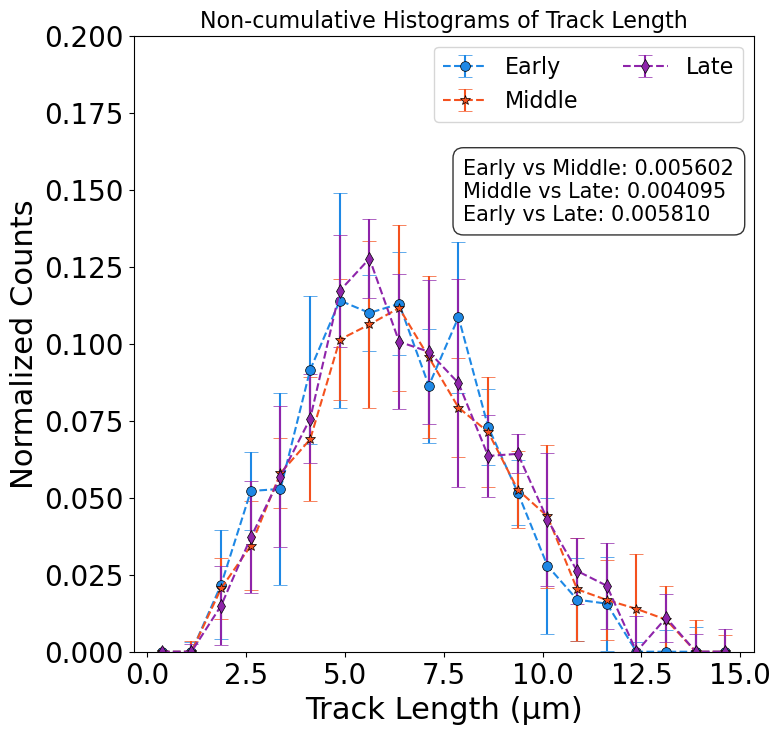

In [113]:
plot_histograms_track_length([tp_trajectories_early, tp_trajectories_middle, tp_trajectories_late], 
                              data_folder=data_folder, weighted=True, cumulative=False, show_middle=True)  

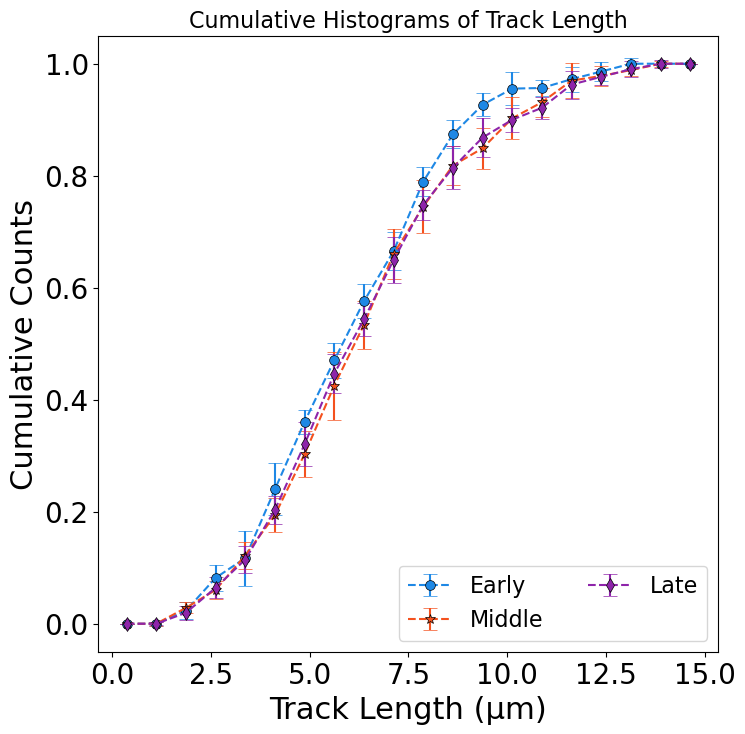

In [123]:
plot_histograms_track_length([tp_trajectories_early, tp_trajectories_middle, tp_trajectories_late], 
                              data_folder=data_folder, weighted=True, cumulative=True, show_middle=True) 

## Inverse Sinuosity

In [120]:
def plot_histograms_sinuosity(df_list, data_folder, weighted=True, 
                              sinuosity_col='sinuosity', track_duration_col='track_duration', 
                              file_address_col='file_address', save_path=None, cumulative=False, show_middle=True):
    """
    Plot histograms of 1/sinuosity for multiple datasets, showing shaded regions for each dataset.
    Allows for both cumulative and non-cumulative histograms.

    Parameters:
    df_list : list of pandas DataFrames
        List containing DataFrames, each with 'sinuosity', 'track_duration', and 'file_address' columns.
    data_folder : str
        Path to the folder where the SVG file will be saved.
    weighted : bool, default True
        Whether to calculate weighted histograms for each file based on track duration.
    sinuosity_col : str, default 'sinuosity'
        The name of the column containing sinuosity values.
    track_duration_col : str, default 'track_duration'
        The name of the column containing track duration values (used for weights if weighted=True).
    file_address_col : str, default 'file_address'
        The name of the column containing file addresses.
    cumulative : bool, default False
        Whether to plot cumulative histograms.
    save_path : str, optional
        Path to save the plot.
    """
    # Define histogram bins and bin centers for 1/sinuosity
    nbins = 20
    bins = np.linspace(0, 1, nbins + 1)  # Adjust as needed
    bin_centers = (bins[:-1] + bins[1:]) / 2

    fig, ax = plt.subplots(figsize=(8, 8))  # Create figure and axis

    # List of labels for the datasets
    dataset_labels = ['Early', 'Middle', 'Late']
    color_labels = ['#1E88E5', '#F4511E', '#8E24AA']
    marker_labels = ["o", "*", "d"]

    # If 'show_middle' is False, remove "Middle" dataset
    if not show_middle:
        df_list = [df_list[0], df_list[2]]  # Keep only Early and Late
        dataset_labels = ['Early', 'Late']
        color_labels = ['#1E88E5', '#8E24AA']
        marker_labels = ["o", "d"]
        
    median_histograms = []

    # Plot histograms for each DataFrame in the list
    for idx, df in enumerate(df_list):
        histograms = []
        file_weights = []

        # Group data by 'file_address' and calculate histograms for each unique file
        for file_address, group_data in df.groupby(file_address_col):
            sinuosity_values = group_data[sinuosity_col]
            
            # Calculate 1/sinuosity
            inverse_sinuosity = 1 / sinuosity_values

            # Apply track_duration as weights if calculating a weighted histogram
            track_weights = group_data[track_duration_col] if weighted else None

            # Compute histogram for the current file_address
            counts, _ = np.histogram(inverse_sinuosity, bins=bins, weights=track_weights, density=False)
            if cumulative:
                counts = np.cumsum(counts)  # Compute cumulative counts
                normalized_counts = counts / counts[-1] if counts[-1] > 0 else counts  # Normalize cumulative counts
            else:
                normalized_counts = counts / counts.sum() if counts.sum() > 0 else counts  # Normalize non-cumulative counts
            histograms.append(normalized_counts)

            # Store the weight based on the number of entries in the group
            file_weights.append(len(group_data))

        # Convert histograms to a numpy array for easier computation
        hist_array = np.array(histograms)

        # Calculate the unweighted median histogram
        median_histogram = np.median(hist_array, axis=0)
        median_histograms.append(median_histogram)

        # Calculate 0.5 * IQR for error bars
        lower_q, upper_q = np.percentile(hist_array, [25, 75], axis=0)
        iqr = upper_q - lower_q
        error_bars = 0.5 * iqr

        # Plot median histogram with error bars
        ax.errorbar(bin_centers, median_histogram, yerr=error_bars, marker=marker_labels[idx], 
                    color=color_labels[idx], label=dataset_labels[idx], linestyle='dashed', 
                    markeredgecolor='black', capsize=5, capthick=1.5, fillstyle='full', 
                    markersize=7, linewidth=1.5, markeredgewidth=0.5, alpha=1.0)


    if cumulative == False:
        # Calculate Wasserstein distances for all phase comparisons
        wasserstein_text = (
            f"Early vs Middle: {wasserstein_distance(median_histograms[0], median_histograms[1], p=1):.6f}\n"
            f"Middle vs Late: {wasserstein_distance(median_histograms[1], median_histograms[2], p=1):.6f}\n"
            f"Early vs Late: {wasserstein_distance(median_histograms[0], median_histograms[2], p=1):.6f}"
        )

        # Annotate Wasserstein distances on the plot
        plt.text(0.5, 0.15, wasserstein_text, fontsize=15, bbox=dict(facecolor='white', edgecolor='black', 
                                                                    boxstyle='round,pad=0.5', alpha=0.8))


    # Set labels and title
    ax.set_xlabel('1/Sinuosity', fontsize=22)
    ax.set_ylabel('Normalized Counts' if not cumulative else 'Cumulative Counts', fontsize=22)
    ax.set_title('Cumulative Histograms of 1/Sinuosity' if cumulative else 'Non-cumulative Histograms of 1/Sinuosity', fontsize=16)

    if cumulative == False:
    # Customize legend
        ax.legend(loc='upper right', fontsize=16, ncol=2)
    else: 
        ax.legend(loc='lower right', fontsize=16, ncol=2)
    
    # Increase tick label font sizes
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.tick_params(axis='both', which='minor', labelsize=20)

    # if cumulative == False:
    #     ax.set_ylim([0, 0.20])
    # else:
    #     ax.set_ylim([-0.05, 1.05]) 
    # Save the plot as SVG file
    if save_path:
        plt.savefig(save_path, format='svg')

    # Show the plot
    plt.show()


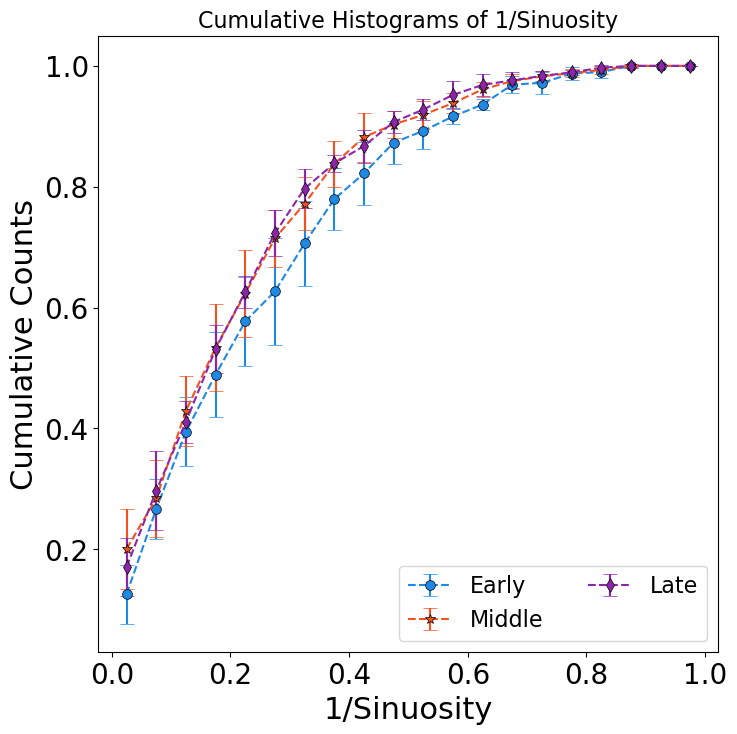

In [122]:
plot_histograms_sinuosity([tp_trajectories_early, tp_trajectories_middle, tp_trajectories_late], 
                              data_folder=data_folder, weighted=True, cumulative=True, show_middle=True)  

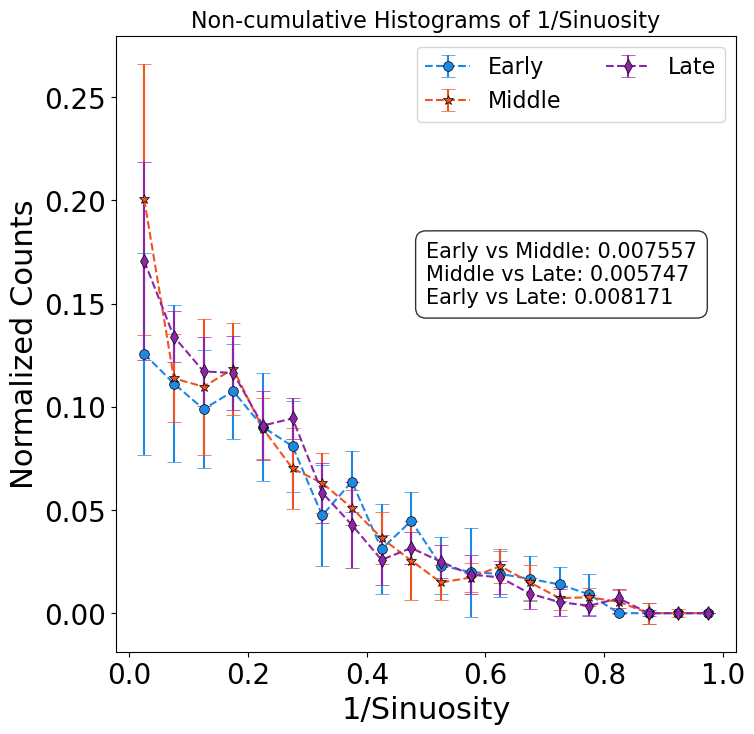

In [124]:
plot_histograms_sinuosity([tp_trajectories_early, tp_trajectories_middle, tp_trajectories_late], 
                              data_folder=data_folder, weighted=True, cumulative=False, show_middle=True)  

## Average Speed
### Non-cumulative


In [55]:
def plot_histograms_average_speed(df_list, data_folder, weighted=True, 
                                  velocity_col='inst_velocity', track_duration_col='track_duration', 
                                  file_address_col='file_address',save_path=None):
    """
    Plot histograms of average speed (instantaneous velocity) for multiple datasets, showing shaded regions for each dataset.
    Calculates a histogram using the median and IQR for error bars.

    Parameters:
    df_list : list of pandas DataFrames
        List containing DataFrames, each with 'inst_velocity', track duration, and file address columns.
    data_folder : str
        Path to the folder where the SVG file will be saved.
    save_name : str
        Base name for the saved SVG file (without extension).
    weighted : bool, default True
        Whether to calculate weighted histograms for each file based on track duration.
    velocity_col : str, default 'inst_velocity'
        The name of the column containing instantaneous velocity values.
    track_duration_col : str, default 'track_duration'
        The name of the column containing track duration values (used for weights if weighted=True).
    file_address_col : str, default 'file_address'
        The name of the column containing file addresses.
    """
    # Define histogram bins and bin centers for average speed (inst_velocity)
    nbins = 20
    bins = np.arange(0, 40 + 40 / nbins, 40 / nbins)
    bin_centers = (bins[:-1] + bins[1:]) / 2

    fig, ax = plt.subplots(figsize=(8, 8))  # Create figure and axis


    # List of labels for the datasets
    dataset_labels = ['Early', 'Middle', 'Late']
    color_labels = ['#1E88E5', '#F4511E', '#8E24AA']
    error_color_labels = ['#1E88E5', '#F4511E', '#8E24AA']
    marker_labels = ["o", "*", "d"]
    median_histograms = []

    # Plot histograms for each DataFrame in the list
    for idx, df in enumerate(df_list):
        histograms = []
        file_weights = []

        # Group data by 'file_address' and calculate histograms for each unique file
        for file_address, group_data in df.groupby(file_address_col):
            velocities = group_data[velocity_col]

            # Apply track_duration as weights if calculating a weighted histogram
            velocity_weights = group_data[track_duration_col] if weighted else None

            # Compute histogram for the current file_address
            counts, _ = np.histogram(velocities, bins=bins, weights=velocity_weights, density=False)
            normalized_counts = counts / counts.sum() if counts.sum() > 0 else counts
            histograms.append(normalized_counts)

            # Store the weight based on the number of entries in the group
            file_weights.append(len(group_data))

        # Convert histograms to a numpy array for easier computation
        hist_array = np.array(histograms)
        file_weights = np.array(file_weights)

        # Calculate the unweighted median histogram by the number of files
        median_histogram = np.median(hist_array, axis=0)
        median_histograms.append(median_histogram)

        # Calculate 0.5 * IQR for error bars
        lower_q, upper_q = np.percentile(hist_array, [25, 75], axis=0)
        iqr = upper_q - lower_q
        error_bars = 0.5 * iqr

        # Plot median histogram with error bars (shaded region)

        if idx==0:
            ax.errorbar(bin_centers, median_histogram, yerr=error_bars, marker = marker_labels[idx], 
                color=color_labels[idx], label=dataset_labels[idx], linestyle='dashed', markeredgecolor='black', capsize=5,
                capthick=1.5, fillstyle = 'full', markersize=9, linewidth=1.5, markeredgewidth=0.5, alpha=1.0)
        else:
            ax.errorbar(bin_centers, median_histogram, yerr=error_bars, marker = marker_labels[idx], 
                color=color_labels[idx], label=dataset_labels[idx], linestyle='dashed', markeredgecolor='black', capsize=5,
                capthick=1.5, fillstyle = 'full', markersize=11, linewidth=1.5, markeredgewidth=0.5, alpha=1.0)

        # Shade the region between the median ± 0.5 * IQR for each dataset
        # plt.fill_between(bin_centers, 
        #                  median_histogram - error_bars, 
        #                  median_histogram + error_bars, color=error_color_labels[idx], alpha=0.1)

    # Compute Wasserstein-2 (p=2) distances
    # wasserstein_text = (
    #     f"Early vs Middle: {wasserstein_distance(median_histograms[0], median_histograms[1], p=1):.6f}\n"
    #     f"Middle vs Late: {wasserstein_distance(median_histograms[1], median_histograms[2], p=1):.6f}\n"
    #     f"Early vs Late: {wasserstein_distance(median_histograms[0], median_histograms[2], p=1):.6f}"
    # )

    # Annotate Wasserstein distances on the plot
    # plt.text(1, 0.14, wasserstein_text, fontsize=20, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5', alpha=0.8))

       # Set labels and title
    ax.set_xlabel('Average Speed (µm/min.)', fontsize=22)
    ax.set_ylabel('Normalized Counts', fontsize=22)
    ax.set_title('Non-cumulative Histograms of Average Speed', fontsize=16)
    
    # Set y-ticks and tick labels
    yticks = np.linspace(0, 0.20, 5)
    ax.set_yticks(yticks)
    ax.set_yticklabels([f"{x:.2f}" for x in yticks], fontsize=20)
    
    # Set y-axis limits
    ax.set_ylim([0, 0.20])
    
    # Customize legend
    ax.legend(loc='upper right', fontsize=16, ncol=2)
    
    # Enable grid
    # ax.grid(True)
    
    # Increase tick label font sizes
    ax.tick_params(axis='both', which='major', labelsize=36)
    ax.tick_params(axis='both', which='minor', labelsize=36)

    print(f"Wasserstein Distance-1 (Early vs Middle): {wasserstein_distance(median_histograms[0], median_histograms[1], p=1):.4f}")  
    print(f"Wasserstein Distance-1 (Middle vs Late): {wasserstein_distance(median_histograms[1], median_histograms[2], p=1):.4f}")  
    print(f"Wasserstein Distance-1 (Early vs Late): {wasserstein_distance(median_histograms[0], median_histograms[2], p=1):.4f}") 
    # Save the plot as SVG file
    if save_path:
        plt.savefig(save_path, format='svg')

    # Show the plot
    plt.show()

Wasserstein Distance-1 (Early vs Middle): 0.0041
Wasserstein Distance-1 (Middle vs Late): 0.0036
Wasserstein Distance-1 (Early vs Late): 0.0036


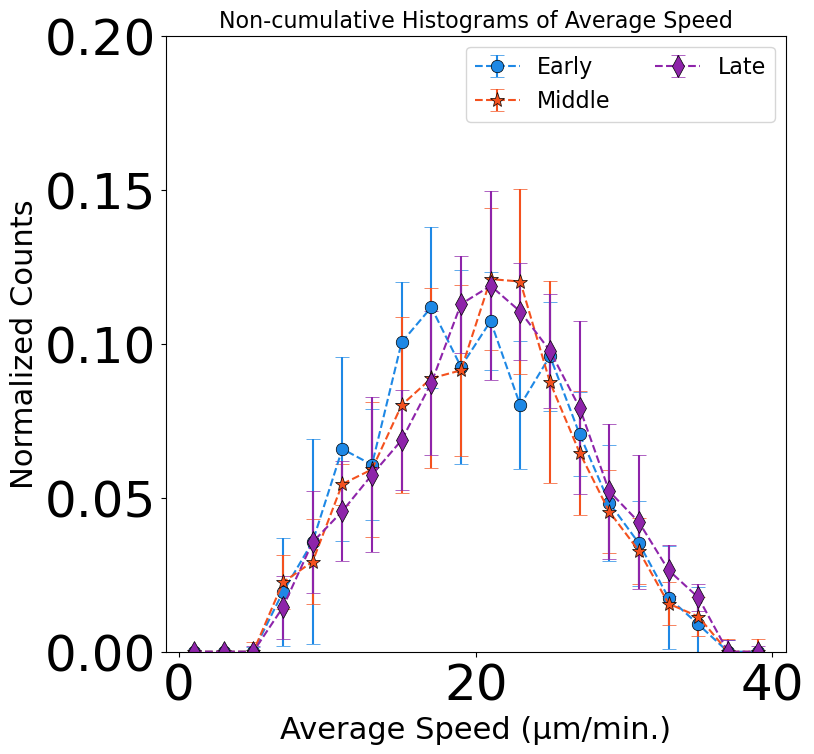

In [56]:
# plot_histograms_average_speed([tp_trajectories_early, tp_trajectories_middle, tp_trajectories_late], 
                              # data_folder=data_folder, weighted=True, save_path=save_folder+'\\early_vs_middle_vs_late_non_cumulative_average_speed.svg')

plot_histograms_average_speed([tp_trajectories_early, tp_trajectories_middle, tp_trajectories_late], 
                              data_folder=data_folder, weighted=True)  



### Cumulative Distribution (old)

In [114]:
def plot_cumulative_distribution(df_list, data_folder, weighted=True, 
                                  velocity_col='inst_velocity', track_duration_col='track_duration', 
                                  file_address_col='file_address', save_path=None):
    """
    Plot cumulative distribution of average speed (instantaneous velocity) for multiple datasets, showing shaded regions for each dataset.
    Calculates the cumulative distribution using the median and IQR for error bars.

    Parameters:
    df_list : list of pandas DataFrames
        List containing DataFrames, each with 'inst_velocity', track duration, and file address columns.
    data_folder : str
        Path to the folder where the SVG file will be saved.
    weighted : bool, default True
        Whether to calculate weighted histograms for each file based on track duration.
    velocity_col : str, default 'inst_velocity'
        The name of the column containing instantaneous velocity values.
    track_duration_col : str, default 'track_duration'
        The name of the column containing track duration values (used for weights if weighted=True).
    file_address_col : str, default 'file_address'
        The name of the column containing file addresses.
    """
    # Define histogram bins and bin centers for average speed (inst_velocity)
    nbins = 20
    bins = np.arange(0, 40 + 40 / nbins, 40 / nbins)
    bin_centers = (bins[:-1] + bins[1:]) / 2

    plt.figure(figsize=(12, 8))

    # List of labels for the datasets
    dataset_labels = ['Early', 'Middle', 'Late']
    color_labels = ['rebeccapurple', '#708A42', '#a0450e']
    error_color_labels = ['rebeccapurple', '#708A42', '#a0450e']

    # Plot histograms for each DataFrame in the list
    for idx, df in enumerate(df_list):
        histograms = []
        file_weights = []

        # Group data by 'file_address' and calculate histograms for each unique file
        for file_address, group_data in df.groupby(file_address_col):
            velocities = group_data[velocity_col]

            # Apply track_duration as weights if calculating a weighted histogram
            velocity_weights = group_data[track_duration_col] if weighted else None

            # Compute histogram for the current file_address
            counts, _ = np.histogram(velocities, bins=bins, weights=velocity_weights, density=False)
            normalized_counts = counts / counts.sum() if counts.sum() > 0 else counts
            histograms.append(normalized_counts)

            # Store the weight based on the number of entries in the group
            file_weights.append(len(group_data))

        # Convert histograms to a numpy array for easier computation
        hist_array = np.array(histograms)
        file_weights = np.array(file_weights)

        # Calculate the unweighted median histogram by the number of files
        median_histogram = np.median(hist_array, axis=0)

        # Calculate cumulative sum of the histogram
        cumulative_histogram = np.cumsum(median_histogram)

        # Calculate 0.5 * IQR for error bars
        lower_q, upper_q = np.percentile(hist_array, [25, 75], axis=0)
        iqr = upper_q - lower_q
        error_bars = 0.5 * iqr

        # Plot cumulative distribution with error bars (shaded region)
        plt.errorbar(bin_centers, cumulative_histogram, yerr=error_bars, fmt='--o', color=color_labels[idx], 
                     label=dataset_labels[idx], capsize=5,capthick=1.5, markersize=7, linewidth=3, alpha=0.7)

        # Shade the region between the median ± 0.5 * IQR for each dataset
        plt.fill_between(bin_centers, 
                         cumulative_histogram - error_bars, 
                         cumulative_histogram + error_bars, color=error_color_labels[idx], alpha=0.1)

    # Add labels, title, legend, and grid
    plt.xlabel('Average Speed (µm/min.)', fontsize=18)
    plt.ylim([-0.05, 1.05])  # Cumulative distribution should range from 0 to 1
    plt.ylabel('Cumulative Distribution', fontsize=18)
    plot_title = 'Cumulative Distribution of Average Speed'
    plt.title(plot_title, fontsize=16)
    plt.legend(loc='upper left', fontsize=16, ncol=2)
    plt.grid(True)

    # Increase tick label font sizes
    plt.tick_params(axis='both', which='major', labelsize=16)
    plt.tick_params(axis='both', which='minor', labelsize=16)

    # Save the plot as SVG file
    if save_path:
        plt.savefig(save_path, format='svg')

    # Show the plot
    plt.show()


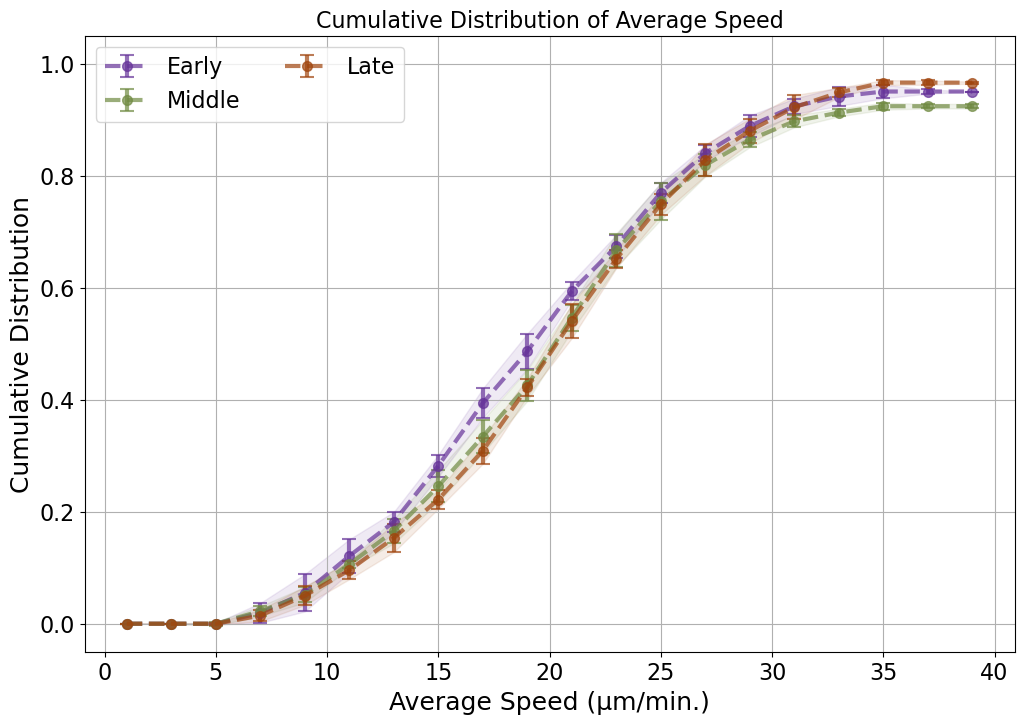

In [115]:
plot_cumulative_distribution([tp_trajectories_early, tp_trajectories_middle, tp_trajectories_late], 
                              data_folder=data_folder, weighted=
                             True, save_path=save_folder+'\\early_vs_middle_vs_late_cumulative_average_speed.svg')  


### Cumulative Distribution

In [150]:
def plot_cumulative_histograms_average_speed(df_list, data_folder, weighted=True, 
                                             velocity_col='inst_velocity', track_duration_col='track_duration', 
                                             file_address_col='file_address', save_path=None):
    """
    Plot cumulative histograms of average speed (instantaneous velocity) for multiple datasets, showing shaded regions for each dataset.
    Also computes Wasserstein-2 distances (p=2) between distributions and displays them on the plot.

    Parameters:
    df_list : list of pandas DataFrames
        List containing DataFrames, each with 'inst_velocity', track duration, and file address columns.
    data_folder : str
        Path to the folder where the SVG file will be saved.
    weighted : bool, default True
        Whether to calculate weighted histograms for each file based on track duration.
    """
    nbins = 20
    bins = np.arange(0, 40 + 40 / nbins, 40 / nbins)
    bin_centers = (bins[:-1] + bins[1:]) / 2

    plt.figure(figsize=(12, 12))

    dataset_labels = ['Early', 'Middle', 'Late']
    color_labels = ['#1E88E5', '#F4511E', '#8E24AA']
    error_color_labels = ['#1E88E5', '#F4511E', '#8E24AA']
    marker_labels = ["o", "*", "d"]

    cumulative_distributions = []

    for idx, df in enumerate(df_list):
        histograms = []
        file_weights = []

        for file_address, group_data in df.groupby(file_address_col):
            velocities = group_data[velocity_col]
            velocity_weights = group_data[track_duration_col] if weighted else None

            counts, _ = np.histogram(velocities, bins=bins, weights=velocity_weights, density=False)
            normalized_counts = counts / counts.sum() if counts.sum() > 0 else counts
            cumulative_counts = np.cumsum(normalized_counts)
            histograms.append(cumulative_counts)
            file_weights.append(len(group_data))

        hist_array = np.array(histograms)
        file_weights = np.array(file_weights)

        median_cumulative = np.median(hist_array, axis=0)
        cumulative_distributions.append(median_cumulative)

        lower_q, upper_q = np.percentile(hist_array, [25, 75], axis=0)
        iqr = upper_q - lower_q
        error_bars = 0.5 * iqr

        if idx == 1:
            plt.errorbar(bin_centers, median_cumulative, yerr=error_bars, marker = marker_labels[idx], 
            color=color_labels[idx], label=dataset_labels[idx], linestyle='dashed', 
            markeredgecolor='black', capsize=5, capthick=1.5, fillstyle = 'full', markersize=11, linewidth=2.5, alpha=1.0)
        else: 
            plt.errorbar(bin_centers, median_cumulative, yerr=error_bars, marker = marker_labels[idx], 
            color=color_labels[idx], label=dataset_labels[idx], linestyle='dashed', 
            markeredgecolor='black', capsize=5, capthick=1.5, fillstyle = 'full', markersize=9, linewidth=2.5, alpha=1.0)

    plt.xlabel('Average Speed (µm/min.)', fontsize=22)
    plt.ylabel('Cumulative Probability', fontsize=22)
    plt.ylim([-0.05, 1.05])
    plt.title('Cumulative Distribution of Average Speed', fontsize=22)
    plt.legend(loc='upper left', fontsize=16, ncol=2)
    # plt.grid(True)
    plt.tick_params(axis='both', which='major', labelsize=20)

    if save_path:
        plt.savefig(save_path, format='svg')

    plt.show()


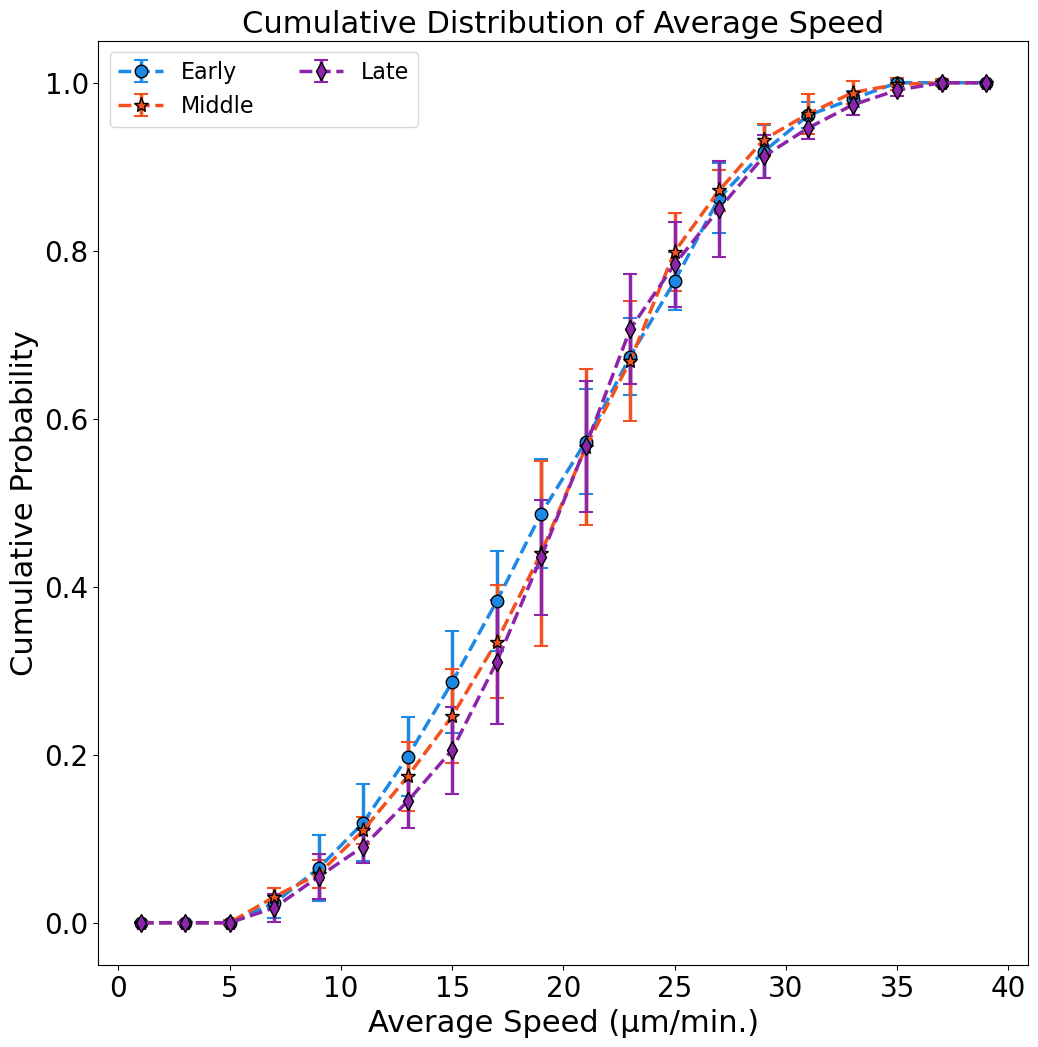

In [151]:
save_folder = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Combined Plots_glass_vs_glass')
plot_cumulative_histograms_average_speed([tp_trajectories_early, tp_trajectories_middle, tp_trajectories_late], 
                              data_folder=data_folder, weighted=
                             True, save_path=save_folder+'\\early_vs_middle_vs_late_cumulative_average_speed_wasserstein.svg')
# plot_cumulative_histograms_average_speed([tp_trajectories_early, tp_trajectories_middle, tp_trajectories_late], 
#                               data_folder=data_folder, weighted=
#                              True)  

### Zoomed-in region

In [185]:
def plot_cumulative_histograms_average_speed(df_list, data_folder, weighted=True, 
                                             velocity_col='inst_velocity', track_duration_col='track_duration', 
                                             file_address_col='file_address', save_path=None):
    """
    Plot cumulative histograms of average speed (instantaneous velocity) for multiple datasets, showing shaded regions for each dataset.
    Also computes Wasserstein-2 distances (p=2) between distributions and displays them on the plot.

    Parameters:
    df_list : list of pandas DataFrames
        List containing DataFrames, each with 'inst_velocity', track duration, and file address columns.
    data_folder : str
        Path to the folder where the SVG file will be saved.
    weighted : bool, default True
        Whether to calculate weighted histograms for each file based on track duration.
    """
    nbins = 20
    bins = np.arange(0, 40 + 40 / nbins, 40 / nbins)
    bin_centers = (bins[:-1] + bins[1:]) / 2

    plt.figure(figsize=(8, 8))

    dataset_labels = ['Early', 'Middle', 'Late']
    color_labels = ['#1E88E5', '#F4511E', '#8E24AA']
    error_color_labels = ['#1E88E5', '#F4511E', '#8E24AA']

    cumulative_distributions = []

    for idx, df in enumerate(df_list):
        histograms = []
        file_weights = []

        for file_address, group_data in df.groupby(file_address_col):
            velocities = group_data[velocity_col]
            velocity_weights = group_data[track_duration_col] if weighted else None

            counts, _ = np.histogram(velocities, bins=bins, weights=velocity_weights, density=False)
            normalized_counts = counts / counts.sum() if counts.sum() > 0 else counts
            cumulative_counts = np.cumsum(normalized_counts)
            histograms.append(cumulative_counts)
            file_weights.append(len(group_data))

        hist_array = np.array(histograms)
        file_weights = np.array(file_weights)

        median_cumulative = np.median(hist_array, axis=0)
        cumulative_distributions.append(median_cumulative)

        lower_q, upper_q = np.percentile(hist_array, [25, 75], axis=0)
        iqr = upper_q - lower_q
        error_bars = 0.5 * iqr

        plt.errorbar(bin_centers, median_cumulative, yerr=error_bars, 
                     fmt='--o', color=color_labels[idx], label=dataset_labels[idx], capsize=5,
                     capthick=1.5, markersize=7, linewidth=2.5, alpha=0.7)

    plt.xlabel('Average Speed (µm/min.)', fontsize=22)
    plt.ylabel('Cumulative Probability', fontsize=22)
    plt.xlim([7, 22])
    plt.ylim([0, 0.7])

    # plt.title('Cumulative Distribution of Average Speed', fontsize=22)
    plt.legend(loc='upper left', fontsize=16, ncol=2)
    plt.grid(True)
    plt.tick_params(axis='both', which='major', labelsize=26)

    if save_path:
        plt.savefig(save_path, format='svg')

    plt.show()


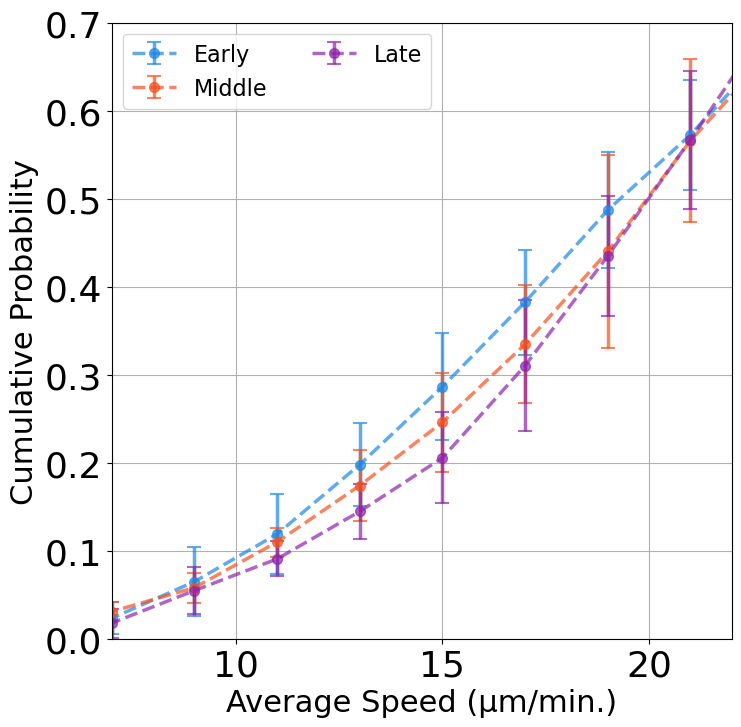

In [186]:
plot_cumulative_histograms_average_speed([tp_trajectories_early, tp_trajectories_middle, tp_trajectories_late], 
                              data_folder=data_folder, weighted=
                             True, save_path=save_folder+'\\early_vs_middle_vs_late_cumulative_average_speed_wasserstein_zoomed.svg')  